In [1]:
import numpy as np
import pandas as pd
from zipfile import ZipFile

# Feature selection
from scipy.stats import pearsonr
from sklearn.feature_selection import mutual_info_classif, f_classif

# Models
from scipy.spatial.distance import euclidean, mahalanobis
from sklearn.metrics.pairwise import rbf_kernel

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler

# Model evaluation
from sklearn import metrics
from kneed import KneeLocator

# Plotting and table formatting
import matplotlib.pyplot as plt
from IPython.display import Markdown
from tabulate import tabulate
import seaborn as sb
from collections import Counter
from tqdm.notebook import tqdm

# System modules
import re
import itertools
import os
import sys
sys.path.append('../')

# Custom modules
from vibrodiagnostics import (
    mafaulda,
    discovery, 
    selection,
    models
)

SOURCE_AXIS = ('ax', 'ay', 'az')
TARGET = 'fault'

PATH_PREFIX = '../../datasets/'
FEATURES_PATH =  os.path.join(PATH_PREFIX, 'features_data')

TD_FD_FEATURES = os.path.join(FEATURES_PATH, selection.TIME_AND_FREQ_FEATURES_PATH)
TD_FEATURES = os.path.join(FEATURES_PATH, selection.TIME_FEATURES_PATH)
FD_FEATURES = os.path.join(FEATURES_PATH, selection.FREQ_FEATURES_PATH)

Parameters:
- Distance metric
- k neighbours (odd numbers because of majority voting) - elbow curve

### Temporal features

In [23]:
def knn_evaluation(x_train, y_train, x_test, y_test):
    knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean', algorithm='kd_tree')
    knn.fit(x_train, y_train)
    y_predict_train = knn.predict(x_train)
    y_predict_test = knn.predict(x_test)

    print(f'Train accuracy: {metrics.accuracy_score(y_train, y_predict_train) * 100:.2f} %')
    print(f'Test accuracy: {metrics.accuracy_score(y_test, y_predict_test) * 100:.2f} %')
    print(metrics.classification_report(y_test, y_predict_test))

    cm = metrics.confusion_matrix(y_test, y_predict_test)
    ax = sb.heatmap(cm, cbar=True, cmap='BuGn', annot=True, fmt='d')
    plt.show()


def knn_one_case_eval(features, x_train, y_train, x_test, y_test):
    x_train_selected = x_train[features]
    x_test_selected = x_test[features]

    knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean', algorithm='kd_tree')
    knn.fit(x_train_selected, y_train)
    y_predict_train = knn.predict(x_train_selected)
    y_predict_test = knn.predict(x_test_selected)

    return {
        'features': features,
        'train_accuracy': metrics.accuracy_score(y_train, y_predict_train),
        'train_precision': metrics.precision_score(y_train, y_predict_train, average='micro'),
        'train_recall': metrics.recall_score(y_train, y_predict_train, average='micro'),
        'test_accuracy': metrics.accuracy_score(y_test, y_predict_test),
        'test_precision': metrics.precision_score(y_test, y_predict_test, average='micro'),
        'test_recall': metrics.recall_score(y_test, y_predict_test, average='micro')
    }

def knn_feature_combinations(all_features, combinations, x_train, y_train, x_test, y_test):
    evaluation = []

    for features in itertools.combinations(all_features, r=combinations):
        result = knn_one_case_eval(list(features), x_train, y_train, x_test, y_test)
        evaluation.append(result)

    evaluation = pd.DataFrame.from_records(evaluation)
    return evaluation.sort_values(by='train_accuracy', ascending=False).reset_index(drop=True)

In [3]:
TRAIN_SET_RATIO = 0.8
ANOMALY_SEVERITY = 0.9
WINDOW_SIZE = 2**14


x_train, y_train, x_test, y_test = models.load_feature_set(
    TD_FEATURES, 
    selection.FAULT_CLASSES,
    SOURCE_AXIS,
    TARGET, 
    train_size=TRAIN_SET_RATIO, 
    anomaly_severity=ANOMALY_SEVERITY,
    balance=True,
    rpm_limit=False,
    window_size=None,
    domain='temporal'
)
scaler = MinMaxScaler()
x_train[x_train.columns] = scaler.fit_transform(x_train)
x_test[x_test.columns] = scaler.transform(x_test)

#### Classification with kNN (all features)

Train accuracy: 95.91 %
Test accuracy: 94.37 %
              precision    recall  f1-score   support

          HM       0.93      0.94      0.94       333
           I       0.99      0.92      0.96       333
           N       0.91      1.00      0.96       333
          VM       0.94      0.91      0.93       333

    accuracy                           0.94      1332
   macro avg       0.95      0.94      0.94      1332
weighted avg       0.95      0.94      0.94      1332



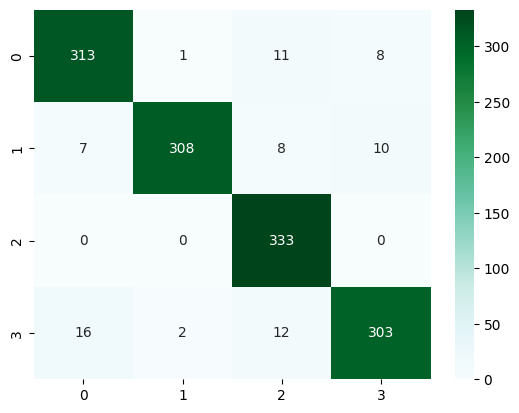

In [4]:
knn_evaluation(x_train, y_train, x_test, y_test)

#### Classification with kNN (choose features)

Train accuracy: 93.37 %
Test accuracy: 90.92 %
              precision    recall  f1-score   support

          HM       0.91      0.91      0.91       333
           I       0.93      0.87      0.90       333
           N       0.88      0.99      0.93       333
          VM       0.92      0.86      0.89       333

    accuracy                           0.91      1332
   macro avg       0.91      0.91      0.91      1332
weighted avg       0.91      0.91      0.91      1332



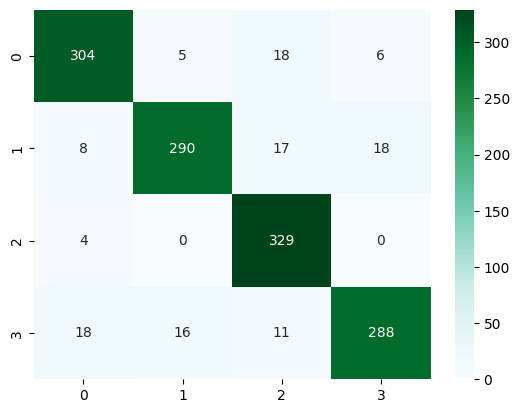

In [5]:
# features = ['std', 'rms', 'pp'] 
features = ['std', 'shape', 'skewness']
knn_evaluation(x_train[features], y_train, x_test[features], y_test)

#### Classification with kNN (all cominations)

In [6]:
# Minimal number of features: 3 (Benchmark: because we need at least 3 PC)  20 seconds (3), 40s (4)
evaluation = knn_feature_combinations(list(x_train.columns), 3, x_train, y_train, x_test, y_test)
evaluation

,features,train_accuracy,train_precision,train_recall,test_accuracy,test_precision,test_recall
0,"[skewness, rms, shape]",0.933746,0.933746,0.933746,0.909159,0.909159,0.909159
1,"[std, skewness, shape]",0.933746,0.933746,0.933746,0.909159,0.909159,0.909159
2,"[skewness, shape, max]",0.919107,0.919107,0.919107,0.893393,0.893393,0.893393
3,"[std, shape, max]",0.913101,0.913101,0.913101,0.888138,0.888138,0.888138
4,"[rms, shape, max]",0.913101,0.913101,0.913101,0.888138,0.888138,0.888138
...,...,...,...,...,...,...,...
115,"[kurtosis, margin, impulse]",0.752815,0.752815,0.752815,0.671171,0.671171,0.671171
116,"[crest, margin, shape]",0.748686,0.748686,0.748686,0.678679,0.678679,0.678679
117,"[crest, impulse, shape]",0.746246,0.746246,0.746246,0.679429,0.679429,0.679429
118,"[margin, impulse, shape]",0.746059,0.746059,0.746059,0.674174,0.674174,0.674174


In [7]:
evaluation.describe()

,train_accuracy,train_precision,train_recall,test_accuracy,test_precision,test_recall
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,0.848123,0.848123,0.848123,0.807070,0.807070,0.807070
std,0.044490,0.044490,0.044490,0.057842,0.057842,0.057842
min,0.743994,0.743994,0.743994,0.653153,0.653153,0.653153
25%,0.816864,0.816864,0.816864,0.772523,0.772523,0.772523
50%,0.861580,0.861580,0.861580,0.822072,0.822072,0.822072
75%,0.873170,0.873170,0.873170,0.844970,0.844970,0.844970
max,0.933746,0.933746,0.933746,0.909159,0.909159,0.909159


---
### Spectral features

In [8]:
WINDOW_SIZE = 2**14

x_train, y_train, x_test, y_test = models.load_feature_set(
    FD_FEATURES, 
    selection.FAULT_CLASSES,
    SOURCE_AXIS,
    'fault', 
    train_size=TRAIN_SET_RATIO, 
    anomaly_severity=ANOMALY_SEVERITY,
    balance=True,
    rpm_limit=False,
    window_size=WINDOW_SIZE,
    domain='spectral'
)
scaler = MinMaxScaler()
x_train[x_train.columns] = scaler.fit_transform(x_train)
x_test[x_test.columns] = scaler.transform(x_test)

#### Classification with kNN (all features)

Train accuracy: 97.54 %
Test accuracy: 95.80 %
              precision    recall  f1-score   support

          HM       0.93      0.96      0.94       333
           I       1.00      0.99      0.99       333
           N       0.95      1.00      0.97       333
          VM       0.96      0.89      0.92       333

    accuracy                           0.96      1332
   macro avg       0.96      0.96      0.96      1332
weighted avg       0.96      0.96      0.96      1332



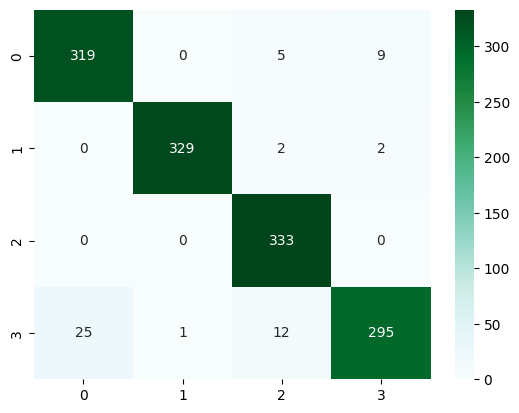

In [9]:
knn_evaluation(x_train, y_train, x_test, y_test)

#### Classification with kNN (choose features)

Train accuracy: 94.13 %
Test accuracy: 91.37 %
              precision    recall  f1-score   support

          HM       0.84      0.88      0.86       333
           I       1.00      0.99      0.99       333
           N       0.91      1.00      0.96       333
          VM       0.90      0.78      0.84       333

    accuracy                           0.91      1332
   macro avg       0.91      0.91      0.91      1332
weighted avg       0.91      0.91      0.91      1332



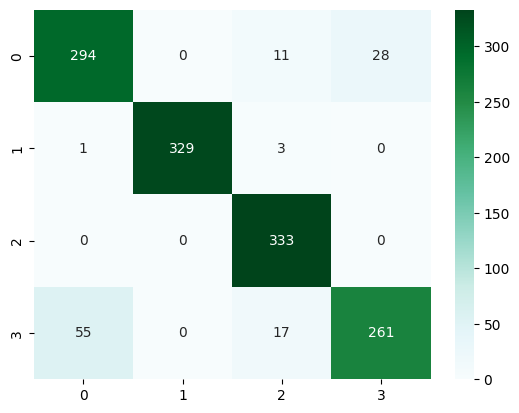

In [10]:
#features = ['entropy', 'std', 'noisiness'] 
features = ['entropy', 'noisiness', 'centroid']
knn_evaluation(x_train[features], y_train, x_test[features], y_test)

In [11]:
# Minimal number of features: 3 (Benchmark: because we need at least 3 PC)  30 seconds (3), 60s (4)
evaluation = knn_feature_combinations(list(x_train.columns), 3, x_train, y_train, x_test, y_test)
evaluation

,features,train_accuracy,train_precision,train_recall,test_accuracy,test_precision,test_recall
0,"[roll_on, roll_off, energy]",0.970908,0.970908,0.970908,0.954204,0.954204,0.954204
1,"[centroid, std, entropy]",0.961336,0.961336,0.961336,0.945946,0.945946,0.945946
2,"[std, roll_on, roll_off]",0.956081,0.956081,0.956081,0.932432,0.932432,0.932432
3,"[std, roll_off, entropy]",0.948386,0.948386,0.948386,0.915916,0.915916,0.915916
4,"[centroid, std, noisiness]",0.947260,0.947260,0.947260,0.921171,0.921171,0.921171
...,...,...,...,...,...,...,...
160,"[std, energy, negentropy]",0.831081,0.831081,0.831081,0.762763,0.762763,0.762763
161,"[std, kurtosis, energy]",0.822823,0.822823,0.822823,0.765766,0.765766,0.765766
162,"[skewness, energy, negentropy]",0.819820,0.819820,0.819820,0.740991,0.740991,0.740991
163,"[skewness, kurtosis, negentropy]",0.816441,0.816441,0.816441,0.777027,0.777027,0.777027


In [12]:
evaluation.describe()

,train_accuracy,train_precision,train_recall,test_accuracy,test_precision,test_recall
count,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000
mean,0.895894,0.895894,0.895894,0.854395,0.854395,0.854395
std,0.028735,0.028735,0.028735,0.038874,0.038874,0.038874
min,0.816254,0.816254,0.816254,0.738739,0.738739,0.738739
25%,0.878191,0.878191,0.878191,0.835586,0.835586,0.835586
50%,0.896396,0.896396,0.896396,0.854354,0.854354,0.854354
75%,0.915541,0.915541,0.915541,0.879129,0.879129,0.879129
max,0.970908,0.970908,0.970908,0.954204,0.954204,0.954204


---

In [27]:
def load_source(dataset: str, domain: str, row: dict):
    RPM = 2900
    RPM_RANGE = 500
    faults = {
        'shaft': {
            'normal': 'N',
            'imbalance': 'I',
            'horizontal-misalignment': 'HM',
            'vertical-misalignment': 'VM'
        },
        'bearings': {
            'overhang-cage_fault': 'O-Cage',
            'underhang-cage_fault': 'U-Cage',
            'underhang-ball_fault': 'U-Ball',
            'overhang-ball_fault': 'O-Ball',
            'underhang-outer_race': 'U-Race',
            'overhang-ball_fault': 'O-Race'
        }
    }
    placements = {
        'A': ['ax', 'ay', 'az'],
        'B': ['bx', 'by', 'bz']
    }

    features = pd.read_csv(dataset).fillna(0)

    # Filter catgories for classification
    classes = faults[row['hardware']]
    features = features[features['fault'].isin(classes)]

    # Choosing rpm range
    if row['rpm_limit']:
        features = features[features['rpm'].between(RPM - RPM_RANGE, RPM + RPM_RANGE, inclusive='both')]

    # Labeling anomaly severity levels
    target = re.search(r'([a-z]+)_?(\d+)?', row['target'])
    anomaly_severity = target.group(2) or '60'
    anomaly_severity = float(anomaly_severity) / 100
    features = models.fault_labeling(features, classes, anomaly_severity)

    # Keeping columns for measurement placement: A, B
    axis = placements['A'] + placements['B'] # TODO: placements[row['placement']]
    columns = features.columns.str.startswith(tuple(axis))
    X = features[features.columns[columns]]

    # Select predicted variable column
    label = target.group(1)
    Y = features[label].astype('category')

    # Filter columns in feature domain with window size 2**14
    if domain == 'spectral':
        window_size = 2**14
        X = X.loc[:,X.columns.str.endswith(f'_{window_size}')]
        X.columns = X.columns.str.extract(r'(\w+)_\w+$')[0]

    # Calculate feature magnitudes from 3D vector
    feature_names = get_features_list({domain: dataset})
    result = pd.DataFrame()
    for name in feature_names:              
        # Remove prefix: temporal, spectral
        name = re.search(r'[a-z]+_([\w\_]+)', name).group(1)
        vector_dims = [f'{dim}_{name}' for dim in axis]
        result[name] = X[vector_dims].apply(np.linalg.norm, axis=1)
    X = result

    # Batch / Online hold-out (balance and event sequencing)
    train_size = 0.8
    # if row['online']:
    #     X_train, X_test, Y_train, Y_test = train_test_split(
    #         X, Y, train_size=train_size, random_state=10
    #     )   
    #     X_train, X_test, Y_train, Y_test = (
    #         X_train.sort_index(), X_test.sort_index(),
    #         Y_train.sort_index(), Y_test.sort_index()
    #     )

    # else:
    oversample = RandomOverSampler(sampling_strategy='not majority', random_state=10)
    X, Y = oversample.fit_resample(X, Y.to_numpy())
    X.reset_index(drop=True, inplace=True)
    Y = pd.Series(Y)

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, train_size=train_size, stratify=Y, random_state=10
    )

    scaler = MinMaxScaler()
    X_train[X_train.columns] = scaler.fit_transform(X_train)
    X_test[X_test.columns] = scaler.transform(X_test)

    return X_train, X_test, Y_train, Y_test

def get_features_list(domains):
    features = []
    for dname, dataset in domains.items():
        names = pd.read_csv(dataset)
        names = names.columns.str.extract(r'([a-z]{2})_([a-z\_\-]+)')[1].unique()
        features.extend([f'{dname}_{col.strip("_")}' for col in names if not pd.isnull(col)])

    return features

def knn_fsel_evaluation(domain, source, exhaustive=False):
    columns = get_features_list({domain: source})
    best_set_membership = pd.read_csv('../FeatureSelection/best_set_membership.csv')
    best_set_membership['target'] = best_set_membership['target'].str.extract(r'([a-z]+)')

    model_td = []
    groupby_columns = ['rpm_limit', 'hardware', 'target']
    for key, group in tqdm(best_set_membership.groupby(by=groupby_columns)):
        situation = group[columns][group == True].count(axis=0).sort_values(ascending=False).head(3)
        features = [re.search(r'[a-z+]_(\w+)', s).group(1) for s in situation.index]

        result = dict(zip(groupby_columns, key))
        x_train, x_test, y_train, y_test = load_source(source, domain, result)
        if exhaustive:
            score = knn_feature_combinations(
                list(x_train.columns), 3, x_train, y_train, x_test, y_test
            ).head(1).to_dict()
        else:
            score = knn_one_case_eval(features, x_train, y_train, x_test, y_test)
        result.update(score)
        model_td.append(result)

    return pd.DataFrame.from_records(model_td)

In [28]:
knn_fsel_evaluation('temporal', TD_FEATURES)  # TODO: elbow analysis (best k for ranking)

  0%|          | 0/8 [00:00<?, ?it/s]

,rpm_limit,hardware,target,features,train_accuracy,train_precision,train_recall,test_accuracy,test_precision,test_recall
0,False,bearings,anomaly,"[std, kurtosis, shape]",0.926911,0.926911,0.926911,0.868802,0.868802,0.868802
1,False,bearings,fault,"[std, pp, skewness]",0.869681,0.869681,0.869681,0.815957,0.815957,0.815957
2,False,shaft,anomaly,"[std, skewness, max]",0.808824,0.808824,0.808824,0.719067,0.719067,0.719067
3,False,shaft,fault,"[std, skewness, pp]",0.796171,0.796171,0.796171,0.725976,0.725976,0.725976
4,True,bearings,anomaly,"[std, shape, crest]",0.979560,0.979560,0.979560,0.968553,0.968553,0.968553
5,True,bearings,fault,"[std, pp, skewness]",0.967424,0.967424,0.967424,0.951515,0.951515,0.951515
6,True,shaft,anomaly,"[std, skewness, pp]",0.890813,0.890813,0.890813,0.846386,0.846386,0.846386
7,True,shaft,fault,"[std, shape, max]",0.862390,0.862390,0.862390,0.804825,0.804825,0.804825


In [15]:
knn_fsel_evaluation('spectral', FD_FEATURES)

  0%|          | 0/8 [00:00<?, ?it/s]

,rpm_limit,hardware,target,features,train_accuracy,train_precision,train_recall,test_accuracy,test_precision,test_recall
0,False,bearings,anomaly,"[entropy, flux, noisiness]",0.930527,0.930527,0.930527,0.910124,0.910124,0.910124
1,False,bearings,fault,"[roll_off, centroid, std]",0.909574,0.909574,0.909574,0.845745,0.845745,0.845745
2,False,shaft,anomaly,"[std, energy, centroid]",0.849899,0.849899,0.849899,0.776876,0.776876,0.776876
3,False,shaft,fault,"[noisiness, centroid, flux]",0.877815,0.877815,0.877815,0.822072,0.822072,0.822072
4,True,bearings,anomaly,"[entropy, flux, noisiness]",0.983491,0.983491,0.983491,0.971698,0.971698,0.971698
5,True,bearings,fault,"[centroid, roll_off, std]",0.965909,0.965909,0.965909,0.942424,0.942424,0.942424
6,True,shaft,anomaly,"[energy, entropy, roll_off]",0.876506,0.876506,0.876506,0.858434,0.858434,0.858434
7,True,shaft,fault,"[entropy, centroid, std]",0.941886,0.941886,0.941886,0.912281,0.912281,0.912281


In [29]:
knn_fsel_evaluation('temporal', TD_FEATURES, exhaustive=True)

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
knn_fsel_evaluation('spectral', FD_FEATURES, exhaustive=True)

---
#### Find best k neighbors - elbow analysis

In [ ]:
def get_knn_error_rates(k_values, X_train, y_train, X_test, y_test):
    errors = []
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree', metric=DIST_METRIC)
        knn.fit(X_train, y_train)
        y_predict = knn.predict(X_test)
        errors.append(np.mean(y_predict != y_test))
    return errors


def get_knn_accuracies(k_values, X_train, y_train, X_test, y_test):
    accuracies = []

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree', metric=DIST_METRIC)
        knn.fit(X_train, y_train)
        y_predict = knn.predict(X_test)
        accuracies.append(metrics.accuracy_score(y_test, y_predict))
    return accuracies


def plot_knn_k_param(k_values, accuracies, error_rates):
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))
    
    ax[0].plot(k_values, accuracies, color='darkblue', marker='o', markerfacecolor='darkgreen', markersize=5)
    ax[0].set_xlabel('K neighbors')
    ax[0].set_ylabel('Accuracy')
    ax[0].grid(True)

    ax[1].plot(k_values, error_rates, color='darkblue', marker='o', markerfacecolor='darkgreen', markersize=5)
    ax[1].set_xlabel('K neighbors')
    ax[1].set_ylabel('Error rate')
    ax[1].grid(True)
    
    plt.show()

In [ ]:
k_values = list(range(3, 40, 2))
accuracies = get_knn_accuracies(k_values, X_train, y_train, X_test, y_test)
error_rates = get_knn_error_rates(k_values, X_train, y_train, X_test, y_test)
plot_knn_k_param(k_values, accuracies, error_rates)

### Change number of features
- evaluate kNN classification accuracies in each feature domain
  - features for each axis separately (x, y, z)
  - features in each measurement poins (a, b)

In [ ]:
TRAINING_SET_RATIO = 0.8
DIST_METRIC = 'euclidean'
FEATURE_SELECTION_METHOD = mutual_info_classif
KNN_K_VALUES = list(range(3, 20, 2))
WINDOW_SIZE = 2**14

def evaluate_knn_number_of_features(features_filename, domain):    
    results = []
    X_train0, y_train0, X_test0, y_test0 = models.load_feature_set(
        features_filename, 
        selection.FAULT_CLASSES,
        SOURCE_AXIS,
        'fault', 
        train_size=TRAINING_SET_RATIO, 
        anomaly_severity=ANOMALY_SEVERITY,
        balance=True,
        rpm_limit=False,
        window_size=WINDOW_SIZE,
        domain=domain
    )
    for n in tqdm(range(1, len(X_train0.columns) + 1)):
        X_train, X_test, y_train, y_test = models.pipeline_v1_core(
            FEATURE_SELECTION_METHOD, n,
            X_train0, y_train0, X_test0, y_test0
        )

        metric = get_knn_error_rates(KNN_K_VALUES, X_train, y_train, X_test, y_test)
        kneedle = KneeLocator(KNN_K_VALUES, metric, S=1.0, curve='convex', direction='decreasing')
        results.append([n, kneedle.elbow, kneedle.knee_y])
    
    return pd.DataFrame(results, columns=['n_features', 'k_neighbors', 'error_rate'])


def find_optimal_error_rate(success):
    plt.plot(success['n_features'], success['error_rate'])
    plt.grid()
    plt.xlabel('Number of features')
    plt.ylabel('Error rate')

    kneedle = KneeLocator(
        success['n_features'], success['error_rate'], 
        S=1.0, curve='convex', direction='decreasing'
    )
    best = success[success['n_features'] == kneedle.elbow]
    return best


def knn_all_evaluate(features_filename, title, domain, subset=None, k=5):
    X_train, y_train, X_test, y_test = models.load_feature_set(
        features_filename, 
        selection.FAULT_CLASSES,
        SOURCE_AXIS,
        'fault', 
        train_size=TRAINING_SET_RATIO, 
        anomaly_severity=ANOMALY_SEVERITY,
        balance=True,
        rpm_limit=False,
        window_size=WINDOW_SIZE,
        domain=domain
    )

    if subset is not None:
        # subset feature columns
        subset = [f'az_{col}' for col in subset]
        X_train = X_train[subset]
        X_test = X_test[subset]

    scaler = MinMaxScaler()
    X_train[X_train.columns] = scaler.fit_transform(X_train)
    X_test[X_test.columns] = scaler.transform(X_test)

    knn = KNeighborsClassifier(n_neighbors=k, metric=DIST_METRIC)
    knn.fit(X_train, y_train)
    y_predict_train = knn.predict(X_train)
    y_predict_test = knn.predict(X_test)

    y_proba_train = knn.predict_proba(X_train)
    y_proba_test = knn.predict_proba(X_test)

    return {
        'feature_set': title,
        'train_accuracy': metrics.accuracy_score(y_train, y_predict_train),
        'train_precision': metrics.precision_score(y_train, y_predict_train, average='micro'),
        'train_recall': metrics.recall_score(y_train, y_predict_train, average='micro'),
        'train_auc': metrics.roc_auc_score(y_train, y_proba_train, multi_class='ovo', average='macro'), # class imbalance insensivity
        'test_accuracy': metrics.accuracy_score(y_test, y_predict_test),
        'test_precision': metrics.precision_score(y_test, y_predict_test, average='micro'),
        'test_recall': metrics.recall_score(y_test, y_predict_test, average='micro'),
        'test_auc': metrics.roc_auc_score(y_test, y_proba_test, multi_class='ovo', average='macro')
    }


def knn_best_evaluate(features_filename, best, domain):
    k_best = best['k_neighbors'].to_numpy()[0]
    n_best = best['n_features'].to_numpy()[0]

    X_train0, y_train0, X_test0, y_test0 = models.load_feature_set(
        features_filename, 
        selection.FAULT_CLASSES,
        SOURCE_AXIS,
        'fault', 
        train_size=TRAINING_SET_RATIO, 
        anomaly_severity=ANOMALY_SEVERITY,
        balance=True,
        rpm_limit=False,
        window_size=WINDOW_SIZE,
        domain=domain
    )

    X_train, X_test, y_train, y_test = models.pipeline_v1_core(
        FEATURE_SELECTION_METHOD, n_best,
        X_train0, y_train0, X_test0, y_test0
    )
    knn = KNeighborsClassifier(n_neighbors=k_best, metric=DIST_METRIC)
    knn.fit(X_train, y_train)
    y_predict_train = knn.predict(X_train)
    y_predict_test = knn.predict(X_test)

    print(f'Train accuracy: {metrics.accuracy_score(y_train, y_predict_train):.4f} %')
    print(f'Test accuracy: {metrics.accuracy_score(y_test, y_predict_test):.4f} %')
    print(metrics.classification_report(y_test, y_predict_test))
    
    print('Most informative features:')
    print(list(X_train.columns))


def kfold_validate_knn(features_filename):
    features = pd.read_csv(FD_FEATURES)
    features = models.fault_labeling(features, selection.FAULT_CLASSES)
    columns = features.columns.str.startswith(tuple(['ax', 'ay', 'az']))
    X = features[features.columns[columns]]
    y = features['fault'].astype('category')

    # crossvalid = StratifiedShuffleSplit(n_splits=5, test_size=0.6, random_state=100)
    crossvalid = StratifiedKFold(n_splits=5)
    evaluation = []

    for train_index, test_index in tqdm(crossvalid.split(X, y)):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]

        X_train, X_test, y_train, y_test = models.pipeline_v1_core(
            FSEL_METHOD, N_FEATURES, 
            X_train, y_train, X_test, y_test
        )

        if DIST_METRIC == 'euclidean':
            d = 'euclidean'
        elif DIST_METRIC == 'mahalanobis':
            d = lambda x, y: mahalanobis(x, y, np.cov(X_train.T))
        elif DIST_METRIC == 'rbf':
            d = lambda x, y: np.exp(-euclidean(x, y)**2 * (1 / len(x)))

        knn = KNeighborsClassifier(n_neighbors=N_NEIGHBOURS, metric=d)
        knn.fit(X_train, y_train)
        y_predict_train = knn.predict(X_train)
        y_predict_test = knn.predict(X_test)

        evaluation.append({
            'train_accuracy': metrics.accuracy_score(y_train, y_predict_train),
            'train_precision': metrics.precision_score(y_train, y_predict_train, average='micro'),
            'train_recall': metrics.recall_score(y_train, y_predict_train, average='micro'),
            'test_accuracy': metrics.accuracy_score(y_test, y_predict_test),
            'test_precision': metrics.precision_score(y_test, y_predict_test, average='micro'),
            'test_recall': metrics.recall_score(y_test, y_predict_test, average='micro')
        })

    print(f'Most informative features: {list(X_train.columns)}')
    evaluation = pd.DataFrame.from_records(evaluation)
    print(evaluation.mean())

#### Feature set #1: Custom features all

In [ ]:
success = evaluate_knn_number_of_features(TD_FD_FEATURES, 'spectral')
success

In [ ]:
best = find_optimal_error_rate(success)
best

In [ ]:
knn_best_evaluate(TD_FD_FEATURES, best, 'spectral')

In [ ]:
#kfold_validate_knn(TD_FD_FEATURES)

#### Feature set #2: Custom time domain features

In [ ]:
success = evaluate_knn_number_of_features(TD_FEATURES, 'temporal')
success

In [ ]:
best = find_optimal_error_rate(success)
best

In [ ]:
knn_best_evaluate(TD_FEATURES, best, 'temporal')

In [ ]:
#kfold_validate_knn(TD_FEATURES)

#### Feature set #3: Custom frequency domain features

In [ ]:
success = evaluate_knn_number_of_features(FD_FEATURES, 'spectral')
success

In [ ]:
best = find_optimal_error_rate(success)
best

In [ ]:
knn_best_evaluate(FD_FEATURES, best, 'spectral')

In [ ]:
#kfold_validate_knn(FD_FEATURES)